In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

df.head()


,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
1,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,2.63,Using ad set budget,2.63,...,2.630000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Feed,Sales,actions:offsite_conversion.fb_pixel_purchase,22.80,Using ad set budget,22.80,...,0.000000,60,1199.0,0.38,730,1756.0,0.031233,228,0.100000,4.56
3,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Facebook Stories,App Installs,actions:mobile_app_install,25.83,Using ad set budget,25.83,...,0.993462,0,0.0,0.00,3,0.0,8.610000,0,0.000000,0.00
4,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.22,103,0.0,1.855340,32,5.971875,0.00


In [14]:
engagement_df = df[df['Objective'] == 'Engagement'].copy()
engagement_df.reset_index(drop=True, inplace=True)
engagement_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2025/0117 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Engagement,actions:post_engagement,185.26,Using ad set budget,185.26,...,0.000000,2,0.0,92.630000,33,0.0,5.613939,32,5.789375,0.000000
1,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Engagement,actions:post_engagement,991.70,Using ad set budget,991.70,...,13.048684,8,499.9,123.962500,170,0.0,5.833529,133,7.456391,991.700000
2,SO/2023/0974 & SO/2023/0973 - Orange - Campagn...,inactive,Facebook,In-app,Facebook Reels,Engagement,actions:post_engagement,2.84,Using ad set budget,2.84,...,0.000000,0,0.0,0.000000,1,0.0,2.840000,0,0.000000,0.000000
3,SO/2024/0390 - Orange - Lancement posts digita...,not_delivering,Facebook,In-app,Facebook Reels,Engagement,actions:post_engagement,1006.19,Using ad set budget,1006.19,...,2.712102,23,0.0,43.747391,434,0.0,2.318410,1068,0.942125,335.396667
4,SO/2023/0974 & SO/2023/0973 - Orange - Campagn...,inactive,Facebook,In-app,Facebook Reels,Engagement,actions:post_engagement,1040.78,Using ad set budget,1040.78,...,0.000000,23,0.0,45.251304,507,0.0,2.052821,29,35.888966,1040.780000


In [15]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

engagement_df_encoded = pd.get_dummies(engagement_df, columns=categorical_cols, drop_first=True)
engagement_df_encoded.head()

,Campaign name,Campaign Delivery,Objective,Result indicator,Ad set budget,Amount spent,Attribution setting,Date created,Starts,Ends,...,Platforme_Facebook,Platforme_Instagram,Placement_Facebook Reels,Placement_Facebook profile feed,Placement_Feed,Placement_In-stream video,Placement_Instagram Reels,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget
0,SO/2025/0117 - Orange - Lancement posts digita...,not_delivering,Engagement,actions:post_engagement,185.26,185.26,7-day click or 1-day view,2025-02-18,2025-02-18,2025-03-22 00:00:00,...,False,True,False,False,True,False,False,False,False,True
1,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Engagement,actions:post_engagement,991.70,991.70,7-day click or 1-day view,2025-01-15,2025-01-16,2025-02-20 00:00:00,...,False,True,False,False,True,False,False,False,False,True
2,SO/2023/0974 & SO/2023/0973 - Orange - Campagn...,inactive,Engagement,actions:post_engagement,2.84,2.84,7-day click or 1-day view,2023-12-26,2023-12-26,2023-12-29 00:00:00,...,True,False,True,False,False,False,False,False,True,True
3,SO/2024/0390 - Orange - Lancement posts digita...,not_delivering,Engagement,actions:post_engagement,1006.19,1006.19,7-day click or 1-day view,2024-05-15,2024-05-15,2024-06-10 00:00:00,...,True,False,True,False,False,False,False,False,True,True
4,SO/2023/0974 & SO/2023/0973 - Orange - Campagn...,inactive,Engagement,actions:post_engagement,1040.78,1040.78,7-day click or 1-day view,2023-12-26,2023-12-26,2023-12-30 00:00:00,...,True,False,True,False,False,False,False,False,True,True


In [38]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
import joblib
import os

engagement_df_encoded['Starts'] = pd.to_datetime(engagement_df_encoded['Starts'])
engagement_df_encoded['day'] = engagement_df_encoded['Starts'].dt.day
engagement_df_encoded['month'] = engagement_df_encoded['Starts'].dt.month
engagement_df_encoded['weekday'] = engagement_df_encoded['Starts'].dt.weekday

# Reapply log1p transformations for all relevant KPIs
engagement_df_encoded['log_spend'] = np.log1p(engagement_df_encoded['Amount spent'])
engagement_df_encoded['log_reach'] = np.log1p(engagement_df_encoded['Reach'])
engagement_df_encoded['log_impressions'] = np.log1p(engagement_df_encoded['Impressions'])
engagement_df_encoded['log_post_eng'] = np.log1p(engagement_df_encoded['Post engagements'])
engagement_df_encoded['log_page_eng'] = np.log1p(engagement_df_encoded['Page engagement'])
engagement_df_encoded['log_reactions'] = np.log1p(engagement_df_encoded['Post reactions'])
engagement_df_encoded['log_comments'] = np.log1p(engagement_df_encoded['Post comments'])
engagement_df_encoded['log_shares'] = np.log1p(engagement_df_encoded['Post shares'])
engagement_df_encoded['log_saves'] = np.log1p(engagement_df_encoded['Post saves'])
engagement_df_encoded['log_cost_per_post_eng'] = np.log1p(engagement_df_encoded['Cost per post engagement (USD)'])
engagement_df_encoded['log_cost_per_page_eng'] = np.log1p(engagement_df_encoded['Cost per Page engagement (USD)'])
engagement_df_encoded['log_follows_likes'] = np.log1p(engagement_df_encoded['Facebook follows or likes'])

# Define the transformer
pt = PowerTransformer(method='yeo-johnson')

# List of KPI columns to transform
kpi_cols = ['Amount spent', 'Reach', 'Impressions', 'Post engagements', 'Page engagement', 'Post reactions', 'Post comments', 
            'Post shares', 'Post saves', 'Cost per post engagement (USD)', 'Cost per Page engagement (USD)', 'Facebook follows or likes']
log_kpi_cols = ['log_spend', 'log_reach', 'log_impressions', 'log_post_eng', 'log_page_eng', 'log_reactions',
               'log_comments', 'log_shares', 'log_saves', 'log_cost_per_post_eng', 'log_cost_per_page_eng', 'log_follows_likes']

engagement_df = engagement_df.dropna(subset=kpi_cols)

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
transformed = pt.fit_transform(engagement_df[kpi_cols])
transformed_cols = ['yj_' + col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for col in kpi_cols]

# Add transformed columns
for i, col in enumerate(transformed_cols):
    engagement_df_encoded[col] = transformed[:, i]
    
#save the transformer
joblib.dump(pt, "models/engagement_power_transformer.joblib")

# Compare skewness
skew_data = pd.DataFrame({
    'Original': [skew(engagement_df[col]) for col in kpi_cols],
    'Log-Transformed': [skew(engagement_df_encoded[col]) for col in log_kpi_cols],
    'Yeo-Johnson': [skew(engagement_df[col]) for col in transformed_cols]

}, index=kpi_cols)

print(skew_data)

                                Original  Log-Transformed  Yeo-Johnson
Amount spent                    2.493128        -0.131764    -0.009512
Reach                           1.992809        -0.332339    -0.025444
Impressions                     3.700990        -0.057794    -0.003027
Post engagements                3.259989         0.176068     0.020619
Page engagement                 3.259849         0.175768     0.020573
Post reactions                  4.169528        -1.177814     0.000447
Post comments                   3.074474         0.084964     0.011859
Post shares                     4.962735        -0.170078    -0.007467
Post saves                      4.758266         0.285868     0.069868
Cost per post engagement (USD)  1.497245         1.414599     0.207777
Cost per Page engagement (USD)  1.500570         1.417734     0.207751
Facebook follows or likes       4.080583         1.059722     0.389234


In [41]:
features_to_keep = [
    'yj_Post_engagements',                  
    'yj_Page_engagement', 'yj_Amount_spent',      
    'yj_Post_reactions', 'yj_Reach', 'yj_Impressions',
    'yj_Post_comments', 'yj_Post_shares', 'yj_Post_saves', 'yj_Cost_per_post_engagement_USD', 
    'yj_Cost_per_Page_engagement_USD', 'yj_Facebook_follows_or_likes',
    'day', 'month', 'weekday']      # Time-based

# Add one-hot encoded categorical columns dynamically
features_to_keep += [col for col in engagement_df_encoded.columns if any(p in col for p in ['Platforme_', 'Placement_', 'Device_', 'Ad set budget type_'])]

# Build final DataFrame
engagement_model_df = engagement_df_encoded[features_to_keep].dropna()

# Separate features and target
X_engagement = engagement_model_df.drop(['yj_Post_engagements', 'yj_Page_engagement'], axis=1)
y_engagement = engagement_model_df[['yj_Post_engagements', 'yj_Page_engagement']]


In [42]:
print("Feature set shape:", X_engagement.shape)
print("Target variable shape:", y_engagement.shape)
X_engagement.head()


Feature set shape: (154, 23)
Target variable shape: (154, 2)


,yj_Amount_spent,yj_Post_reactions,yj_Reach,yj_Impressions,yj_Post_comments,yj_Post_shares,yj_Post_saves,yj_Cost_per_post_engagement_USD,yj_Cost_per_Page_engagement_USD,yj_Facebook_follows_or_likes,...,Platforme_Facebook,Platforme_Instagram,Placement_Facebook Reels,Placement_Facebook profile feed,Placement_Feed,Placement_In-stream video,Placement_Instagram Reels,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget
0,0.093503,0.681016,-1.260200,-0.954828,-0.261835,0.350541,1.156805,0.817141,0.818515,-0.964958,...,False,True,False,False,True,False,False,False,False,True
1,1.259057,1.630370,-0.562360,-0.003905,-0.261835,1.007247,1.747510,1.304150,1.305579,-0.964958,...,False,True,False,False,True,False,False,False,False,True
2,-2.350944,-1.166447,-2.147338,-2.368541,-1.345484,-1.881789,-1.406239,-1.061475,-1.061503,-0.964958,...,True,False,True,False,False,False,False,False,True,True
3,1.269466,1.545715,0.744995,0.897870,1.273555,1.364507,0.748229,0.716759,0.717359,1.283629,...,True,False,True,False,False,False,False,False,True,True
4,1.293741,1.107464,1.470303,1.160893,1.508730,0.885320,1.102662,0.753800,0.758842,-0.964958,...,True,False,True,False,False,False,False,False,True,True


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_engagement, y_engagement, test_size=0.2, random_state=42
)


In [44]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(type(X_train), type(y_train))

X_train shape: (123, 23)
y_train shape: (123, 2)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [45]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 9. Define Models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge())
}

In [55]:
best_model = None
best_score = -np.inf
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_Post_Eng = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
    r2_Post_Eng = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
    mae_Post_Eng = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])

    rmse_Page_Eng = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
    r2_Page_Eng = r2_score(y_test.iloc[:, 1], y_pred[:, 1])
    mae_Page_Eng = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])

    print(f"{name}")
    print(f"Post Eng - RMSE: {rmse_Post_Eng:.4f} | MAE: {mae_Post_Eng:.4f} | R²: {r2_Post_Eng:.4f}")
    print(f"Page Eng - RMSE: {rmse_Page_Eng:.4f} | MAE: {mae_Page_Eng:.4f} | R²: {r2_Page_Eng:.4f}")
    print("-" * 50)

    metrics_summary.append({
        "Model": name,
        "Post_eng RMSE": rmse_Post_Eng,
        "Post_eng MAE": mae_Post_Eng,
        "Post_eng R2": r2_Post_Eng,
        "Page_eng RMSE": rmse_Page_Eng,
        "Page_eng MAE": mae_Page_Eng,
        "Page_eng R2": r2_Page_Eng
    })

    if r2_Post_Eng + r2_Page_Eng > best_score:
        best_score = r2_Post_Eng + r2_Page_Eng
        best_model = model
        best_name = name

Linear Regression
Post Eng - RMSE: 0.2532 | MAE: 0.1959 | R²: 0.9283
Page Eng - RMSE: 0.2532 | MAE: 0.1958 | R²: 0.9283
--------------------------------------------------
Ridge Regression
Post Eng - RMSE: 0.2479 | MAE: 0.1950 | R²: 0.9313
Page Eng - RMSE: 0.2478 | MAE: 0.1949 | R²: 0.9313
--------------------------------------------------
Random Forest
Post Eng - RMSE: 0.1620 | MAE: 0.1209 | R²: 0.9706
Page Eng - RMSE: 0.1642 | MAE: 0.1205 | R²: 0.9699
--------------------------------------------------
Bayesian Ridge
Post Eng - RMSE: 0.2484 | MAE: 0.1951 | R²: 0.9310
Page Eng - RMSE: 0.2483 | MAE: 0.1950 | R²: 0.9311
--------------------------------------------------


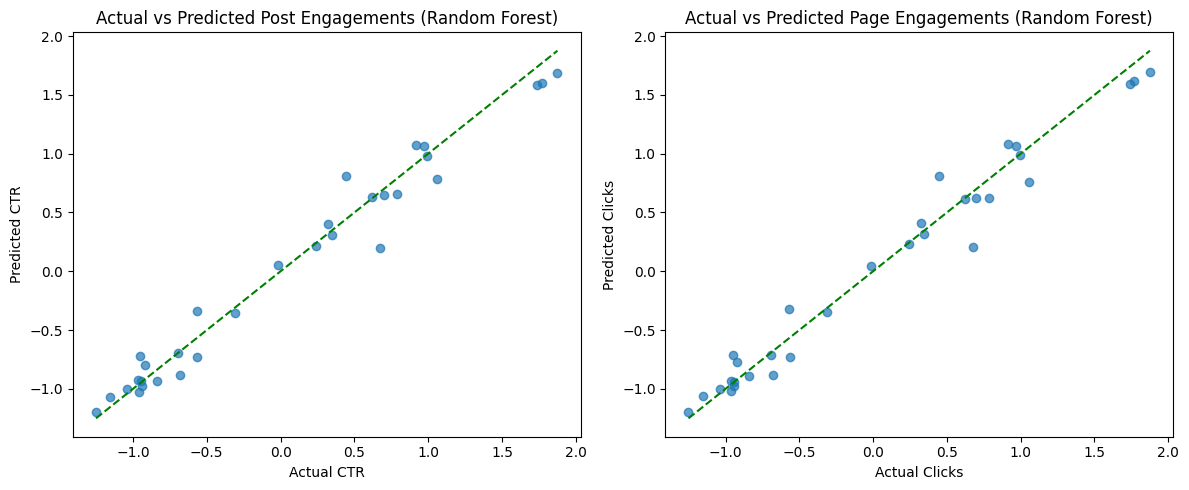

In [56]:
# 12. Actual vs Predicted Plot for Best Model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test.iloc[:, 0], y_pred_best[:, 0], alpha=0.7)
plt.plot([y_test['yj_Post_engagements'].min(), y_test['yj_Post_engagements'].max()],
         [y_test['yj_Post_engagements'].min(), y_test['yj_Post_engagements'].max()], '--g')
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title(f"Actual vs Predicted Post Engagements ({best_name})")

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[:, 1], y_pred_best[:, 1], alpha=0.7)
plt.plot([y_test['yj_Page_engagement'].min(), y_test['yj_Page_engagement'].max()],
         [y_test['yj_Page_engagement'].min(), y_test['yj_Page_engagement'].max()], '--g')
plt.xlabel("Actual Clicks")
plt.ylabel("Predicted Clicks")
plt.title(f"Actual vs Predicted Page Engagements ({best_name})")

plt.tight_layout()
plt.show()

In [57]:
# 13. Cross-Validation for Best Model
cv_r2 = cross_val_score(best_model, X_engagement, y_engagement, scoring='r2', cv=5)
cv_rmse = np.sqrt(-cross_val_score(best_model, X_engagement, y_engagement, scoring='neg_mean_squared_error', cv=5))
cv_mae = -cross_val_score(best_model, X_engagement, y_engagement, scoring='neg_mean_absolute_error', cv=5)

In [63]:
print(f"""
### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict Post and Page engagements:

🔹 **Best Model:** {best_name}  
📈 Post engagements R²: {metrics_summary[2]['Post_eng R2']:.4f}  
📈 Page engagements R²: {metrics_summary[2]['Page_eng R2']:.4f}  

✅ **Cross-Validation Results:**  
Avg R²: {np.mean(cv_r2):.4f}  
Avg RMSE: {np.mean(cv_rmse):.4f}  
Avg MAE: {np.mean(cv_mae):.4f}

The scatter plots confirm this model's predictions align closely with actual values.
""")


### ✅ Traffic Campaign Modeling Summary

We tested 4 models to predict Post and Page engagements:

🔹 **Best Model:** Random Forest  
📈 Post engagements R²: 0.9706  
📈 Page engagements R²: 0.9699  

✅ **Cross-Validation Results:**  
Avg R²: 0.6424  
Avg RMSE: 0.3432  
Avg MAE: 0.2716

The scatter plots confirm this model's predictions align closely with actual values.



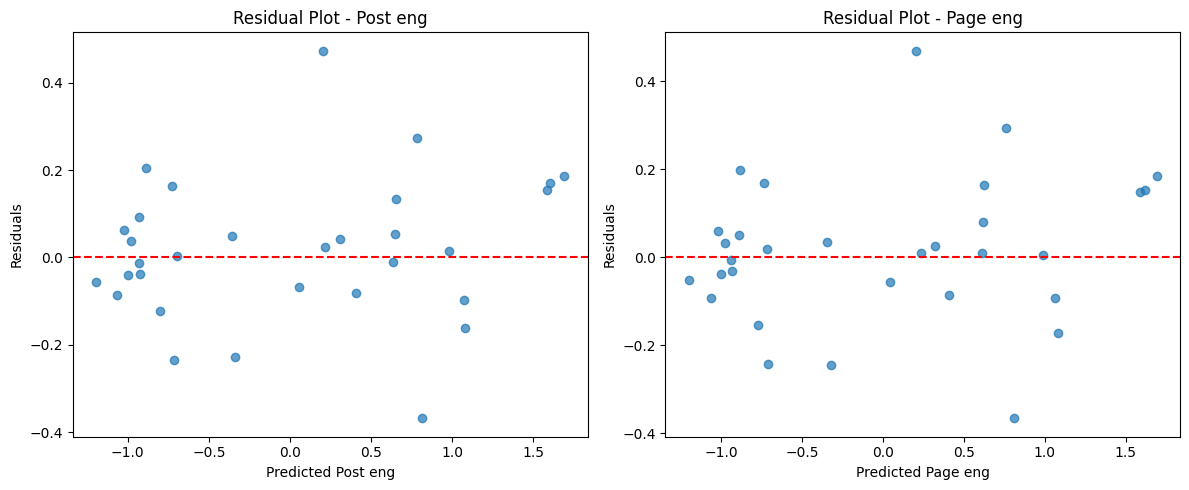

In [64]:
# 14. Residual Plot for Best Model
residuals_Post_eng = y_test.iloc[:, 0] - y_pred_best[:, 0]
residuals_Page_eng = y_test.iloc[:, 1] - y_pred_best[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best[:, 0], residuals_Post_eng, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Post eng")
plt.ylabel("Residuals")
plt.title("Residual Plot - Post eng")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_best[:, 1], residuals_Page_eng, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Page eng")
plt.ylabel("Residuals")
plt.title("Residual Plot - Page eng")

plt.tight_layout()
plt.show()

In [65]:
# 17. Save best model
joblib.dump(best_model, f"models/{best_name.lower().replace(' ', '_')}_engagement_model.joblib")

['models/random_forest_engagement_model.joblib']